In [1]:
import time
import keras_core as ks
from keras_core import ops
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from kgcnn.data.datasets.CoraLuDataset import CoraLuDataset
from kgcnn.literature.GCN import make_model
from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
from kgcnn.training.scheduler import LinearLearningRateScheduler

Using TensorFlow backend


## Loading graph data

In [2]:
dataset = CoraLuDataset()
dataset.map_list(**{"method": "make_undirected_edges"})
dataset.map_list(**{"method": "add_edge_self_loops"})
dataset.map_list(**{"method": "normalize_edge_weights_sym"})
dataset.map_list(**{"method": "count_nodes_and_edges"})
dataset[0]["node_attributes"] = dataset[0]["node_attributes"][:, 1:]  # remove ids
class_label_mapping = dataset.class_label_mapping

# Find a color to visualize a label
def get_label_color(label):
    return plt.get_cmap('Set1')(label / 7)

# Map label to class
def get_label_name(label):
    return ["Case_Based",
            "Genetic_Algorithms",
            "Neural_Networks",
            "Probabilistic_Methods",
            "Reinforcement_Learning",
            "Rule_Learning",
            "Theory"][label]


INFO:kgcnn.data.download:Checking and possibly downloading dataset with name cora_lu
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


## Train test split

In [3]:
model_inputs = [
        {'shape': (None, 1432), 'name': "node_attributes", 'dtype': 'float32'},
        {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32'},
        {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64'},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_edges", "dtype": "int64"}
    ]

In [4]:
# Make test/train split
# Since only one graph in the dataset
# Use a mask to hide test nodes labels
labels = dataset.get("node_labels")[0]
inds = np.arange(len(labels))
ind_train, ind_val = train_test_split(inds, test_size=0.10, random_state=0)
val_mask = np.zeros_like(inds)
train_mask = np.zeros_like(inds)
val_mask[ind_val] = 1
train_mask[ind_train] = 1
val_mask = np.expand_dims(val_mask, axis=0)  # One graph in batch
train_mask = np.expand_dims(train_mask, axis=0)  # One graph in batch

# Set training data. But requires mask and batch-dimension of 1
xtrain = dataset.tensor(model_inputs)
ytrain = np.expand_dims(labels, axis=0)  # One graph in batch
print([x.shape for x in xtrain])
print(ytrain.shape)

[(1, 2708, 1432), (1, 13264, 1), (1, 13264, 2), (1,), (1,)]
(1, 2708, 7)


## Train GCN model on cora dataset

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'GCN', 'inputs': [{'shape': (None, 1432), 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': (None, 1), 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'input_embedding': None, 'cast_disjoint_kwargs': {}, 'input_node_embedding': {'input_dim': 95, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 25, 'output_dim': 1}, 'gcn_args': {'units': 124, 'use_bias': True, 'activation': 'relu', 'pooling_method': 'sum'}, 'depth': 3, 'verbose': 10, 'node_pooling_args': {'pooling_method': 'scatter_sum'}, 'output_embedding': 'node', 'output_to_tensor': None, 'output_tensor_type': 'padded', 'output_mlp': {'use_bias': [True, True, False], 'units': [64, 16, 7], 'activation': ['relu', 'relu', 'softmax']}, 'output_scaling': None}'.


Model: "GCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 1432)        │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 1432), (None),    │           0 │ node_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 1)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense (Dense)                 │ (None, 124)               │     177,692 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 1), (None),       │           0 │ edge_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 1432), (2, None), │           0 │ node_attributes[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ edge_indices[0][0],            │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn (GCN)                     │ (None, 124)               │      15,500 │ dense[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_1 (GCN)                   │ (None, 124)               │      15,500 │ gcn[0][0],                     │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_2 (GCN)                   │ (None, 124)               │      15,500 │ gcn_1[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ 

 Total params: 233,344 (911.50 KB)

 Trainable params: 233,344 (911.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Print Time for taining:  172.5625


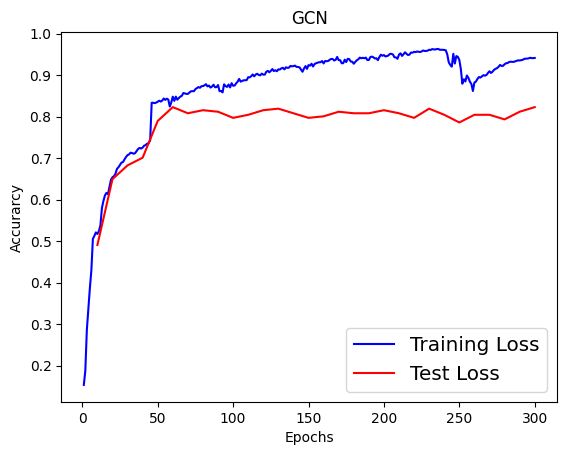

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - categorical_accuracy: 0.8229 - loss: 0.1132


[0.11321771144866943, 0.8228783011436462]

In [5]:
model = make_model(
    inputs=model_inputs,
    gcn_args = {"units": 124, "use_bias": True, "activation": 'relu', "pooling_method": 'sum'},
    depth = 3, 
    verbose =  10,
    output_embedding = 'node',
    output_mlp = {"use_bias": [True, True, False], "units": [64, 16, 7], "activation": ['relu', 'relu', 'softmax']},
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 300
epomin = 260
epostep = 10

# Compile model with optimizer and loss
optimizer = ks.optimizers.Adam(learning_rate=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['categorical_accuracy'])
print(model.summary())

# Training loop
trainlossall = []
testlossall = []
start = time.process_time()
for iepoch in range(0, epo, epostep):
    hist = model.fit(xtrain, ytrain,
                     epochs=iepoch + epostep,
                     initial_epoch=iepoch,
                     batch_size=1,
                     callbacks=[cbks],
                     verbose=0,
                     sample_weight=train_mask  # Important!!!
                     )

    trainlossall.append(hist.history)
    testlossall.append(model.evaluate(xtrain, ytrain, sample_weight=val_mask, verbose=0))
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Pick out accuracy
testlossall = np.array(testlossall)
trainlossall = np.concatenate([x['categorical_accuracy'] for x in trainlossall])

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(1, len(trainlossall) + 1), trainlossall, label='Training Loss', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall[:, 1], label='Test Loss', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GCN')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gcn_explain_loss_cora.png')
plt.show()

# Evaluate model
model.evaluate(xtrain, ytrain, sample_weight=val_mask)

## Explaining Predictions


Implementing the GNNInterface:

In [6]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, node_index, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model
        self.node_index = node_index

    def predict(self, gnn_input, masking_info=None):
        return ops.expand_dims(self.gnn_model(gnn_input, training=False)[0][self.node_index], 0)

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input, node_len, edge_len = gnn_input

        node_len = ops.convert_to_tensor(node_len)
        edge_len = ops.convert_to_tensor(edge_len)
        edge_index_input = ops.convert_to_tensor(edge_index_input)
        masked_edge_input = ops.convert_to_tensor(edge_input) * ops.cast(edge_mask, dtype="float32")
        masked_feature_input = ops.convert_to_tensor(node_input) * ops.cast(ops.transpose(feature_mask), dtype="float32")
        masked_pred = ops.expand_dims(
            self.gnn_model([masked_feature_input, masked_edge_input, edge_index_input, node_len, edge_len], training=training)[0][
                self.node_index], 0)
        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _, _ ,_ = gnn_input
        return node_input[0].shape[1]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _, _, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask, node_labels=None):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        g = nx.Graph()
        for i, f in enumerate(features):
            if node_labels is None:
                g.add_node(i, features=f, relevance=node_relevance[i])
            else:
                g.add_node(i, features=f, relevance=node_relevance[i], label=node_labels[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                g.add_edge(e[0], e[1])
            else:
                g.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return g

    def present_explanation(self, explanation, threshold=0.5):
        relevant_edges = []
        edge_color_map = []
        for (v, u, relevance) in explanation.edges.data('relevance'):
            if relevance > threshold:
                relevant_edges.append((v, u))
                edge_color_map.append((0, 0, 0, relevance))
        subgraph = explanation.edge_subgraph(relevant_edges)
        node_colors = []
        for n, l in subgraph.nodes.data('label'):
            r, g, b, a = get_label_color(l)
            a = subgraph.nodes[n]['relevance']
            node_colors.append((r, g, b, a))
        nx.draw(subgraph, node_color=node_colors, edge_color=edge_color_map, with_labels=True)

In [7]:
# Helper functions
def get_output_tensor_for_label(label):
    assert 0 <= label <= 6
    output_to_explain = np.zeros(7)
    output_to_explain[label] = 1.
    output_to_explain = np.expand_dims(output_to_explain, 0)
    return tf.Variable(output_to_explain)


def get_label_from_tensor(tensor_output):
    return np.argmax(tensor_output)

Choose a node to explain and instantiate an explainable GNN:

In [8]:
node_index = np.argwhere(val_mask[0] == 1)[:, 0][0]
# node_index = 9
explainable_gcn = ExplainableGCN(model, node_index)

Get the prediction of the GNN for the chosen node:

In [9]:
prediction = explainable_gcn.predict(xtrain)
predicted_label = get_label_from_tensor(prediction)
print('predicted label: ', predicted_label, get_label_name(predicted_label))
print("true label:", get_label_from_tensor(labels[node_index]))
print('node_index: ', node_index)

predicted label:  2 Neural_Networks
true label: 2
node_index:  9


Setup the GNNExplainer:

In [10]:
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                                 'edge_mask_norm_ord': 2,
                                 'feature_mask_loss_weight': 0,
                                 'feature_mask_norm_ord': 2,
                                 'node_mask_loss_weight': 0,
                                 'node_mask_norm_ord': 1}
compile_options = {'loss': 'categorical_crossentropy', 'optimizer': ks.optimizers.Adam(learning_rate=1.0)}
fit_options = {'epochs': 80, 'verbose': 2}

explainer = GNNExplainer(explainable_gcn,
                         compile_options=compile_options,
                         fit_options=fit_options,
                         gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

Explain the instance with index node_index:

In [11]:
%%capture
inspection_result = explainer.explain(xtrain, inspection=True)

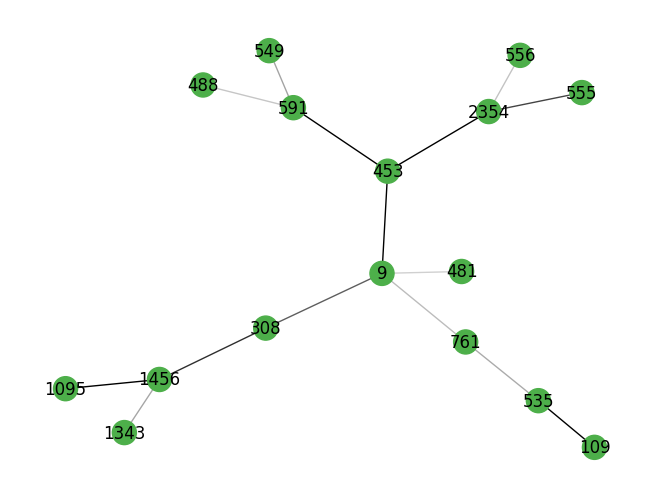

In [12]:
plt.figure()
explainer.present_explanation(explainer.get_explanation(node_labels=np.argmax(ytrain[0], axis=1)), threshold=0.1)
plt.show()

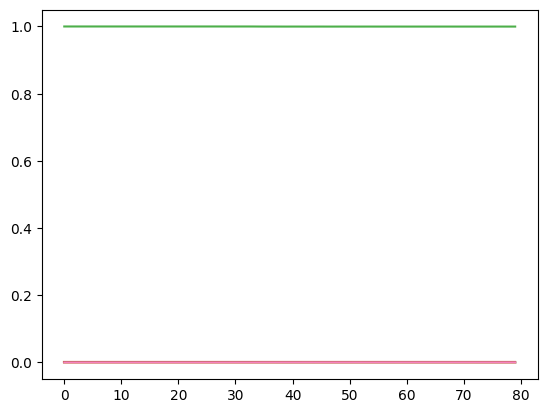

In [13]:
# Plot the inspection_result to see if we chose suitable parameters:
plt.figure()
for i in range(7):
    plt.plot(np.array(inspection_result['predictions'])[:, i], color=get_label_color(i))
plt.show()

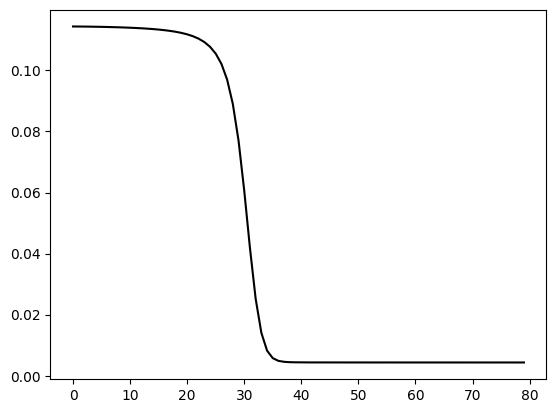

In [14]:
# Plot Loss
plt.figure()
plt.plot(np.array(inspection_result['total_loss']), color="black")
plt.show()

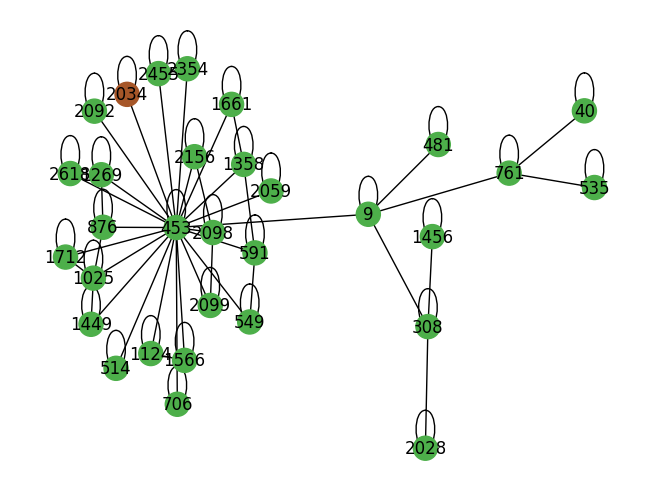

In [15]:
# For comparison, the 2-hop graph around the chosen instance:
plt.figure()
cora_graph = nx.Graph()
cora_graph.add_nodes_from([(i, {"label": labels[i]}) for i in inds])
cora_graph.add_edges_from(dataset.get("edge_indices")[0])
hops = 2
khopgraph = nx.generators.ego.ego_graph(cora_graph, node_index, radius=hops)
for n in khopgraph.nodes:
    khopgraph.nodes[n]['label'] = np.argmax(khopgraph.nodes[n]['label'])
    khopgraph.nodes[n]['relevance'] = 1.
for (u, v) in khopgraph.edges:
    khopgraph.edges[u, v]['relevance'] = 1.0
explainer.present_explanation(khopgraph)
plt.show()